In [1]:
import sys
import os

In [2]:
PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from yield_curve.data_loader import load_treasury_yields
from yield_curve.curve_builder import YieldCurve
from yield_curve.rates import zero_rate, forward_rate, instantaneous_forward_rates
from bond_engine.key_rate_shock import key_rate_duration, KeyRateShockedCurve
from bond_engine.portfolio import BondPortfolio
from bond_engine.rate_shock import ShockedYieldCurve
from bond_engine.bond_pricer import Bond, price_bond, yield_to_maturity
from bond_engine.bond_pricer import (
    macaulay_duration,
    modified_duration,
    convexity
)

In [5]:
df = load_treasury_yields(start="2024-01-01")
latest = df.iloc[-1]
print(latest)

yc = YieldCurve(latest)

print("2.75Y rate:", yc.rate(2.75))
print("7Y rate:", yc.rate(7))
print("10Y DF:", yc.discount_factor(10))

1M     0.0372
3M     0.0368
6M     0.0359
1Y     0.0345
2Y     0.0350
5Y     0.0376
10Y    0.0422
30Y    0.0485
Name: 2026-02-06 00:00:00, dtype: float64
2.75Y rate: 0.03587929000563622
7Y rate: 0.03931422290105776
10Y DF: 0.6557340393934418


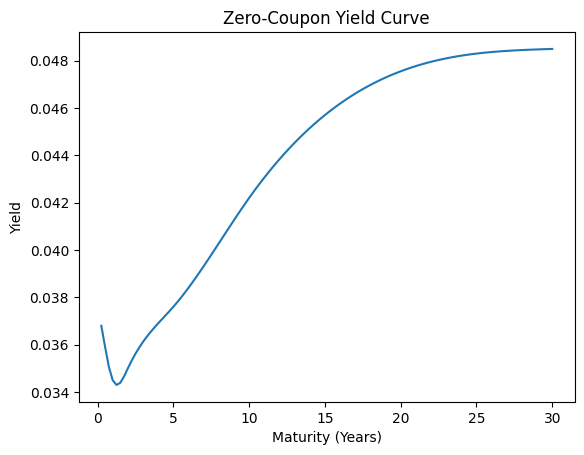

In [6]:
maturities = np.linspace(0.25, 30, 120)
zero_rates = [zero_rate(yc, t) for t in maturities]

plt.plot(maturities, zero_rates)
plt.title("Zero-Coupon Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.show()

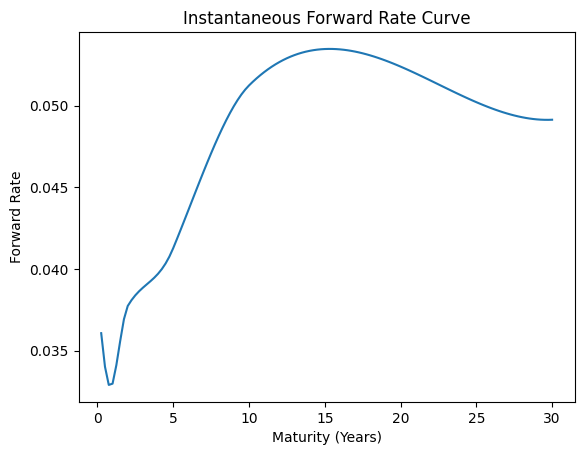

In [7]:
forward_rates = instantaneous_forward_rates(yc, maturities)

plt.plot(maturities, forward_rates)
plt.title("Instantaneous Forward Rate Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Forward Rate")
plt.show()

In [8]:
bond = Bond(
    face_value=100,
    coupon_rate=0.06,
    maturity=5,
    frequency=2
)

price = price_bond(bond, yc)
print("Bond price:", round(price, 2))

ytm = yield_to_maturity(bond, price)
print("Implied YTM:", round(ytm * 100, 2), "%")

Bond price: 110.04
Implied YTM: 3.74 %


In [10]:
D_mac = macaulay_duration(bond, yc)
D_mod = modified_duration(bond, yc)
C = convexity(bond, yc)

print(f"Macaulay Duration: {D_mac:.2f} years")
print(f"Modified Duration: {D_mod:.2f}")
print(f"Convexity: {C:.2f}")

Macaulay Duration: 4.42 years
Modified Duration: 4.26
Convexity: 21.10


In [12]:
shocks = [-100, -50, 50, 100]  # bp
base_price = price_bond(bond, yc)

results = []

for s in shocks:
    shocked_curve = ShockedYieldCurve(yc, s)
    shocked_price = price_bond(bond, shocked_curve)

    results.append({
        "Shock (bp)": s,
        "Price": shocked_price,
        "Pct Change": (shocked_price / base_price - 1) * 100
    })

pd.DataFrame(results)

,Shock (bp),Price,Pct Change
0,-100,115.027344,4.532172
1,-50,112.504003,2.239063
2,50,107.634305,-2.186320
3,100,105.285115,-4.321169


In [13]:
D = modified_duration(bond, yc)
C = convexity(bond, yc)

approx_results = []

for s in shocks:
    dy = s / 10000
    approx_pct = -D * dy + 0.5 * C * dy**2

    approx_results.append({
        "Shock (bp)": s,
        "Approx % Change": approx_pct * 100
    })

pd.DataFrame(approx_results)

,Shock (bp),Approx % Change
0,-100,4.370086
1,-50,2.158673
2,50,-2.105932
3,100,-4.159124


In [14]:
df_actual = pd.DataFrame(results).set_index("Shock (bp)")
df_approx = pd.DataFrame(approx_results).set_index("Shock (bp)")

comparison = df_actual.join(df_approx)
comparison

,Price,Pct Change,Approx % Change
Shock (bp),,,
-100,115.027344,4.532172,4.370086
-50,112.504003,2.239063,2.158673
50,107.634305,-2.186320,-2.105932
100,105.285115,-4.321169,-4.159124


<Axes: title={'center': 'Actual vs Duration+Convexity Approximation'}, xlabel='Shock (bp)'>

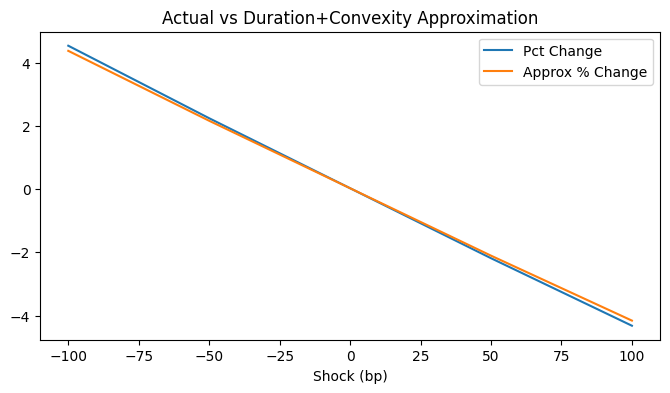

In [15]:
comparison[["Pct Change", "Approx % Change"]].plot(
    title="Actual vs Duration+Convexity Approximation",
    figsize=(8, 4)
)

In [17]:
bond_short = Bond(100, 0.04, 2)
bond_mid   = Bond(100, 0.05, 5)
bond_long  = Bond(100, 0.07, 10)

portfolio = BondPortfolio(
    bonds=[bond_short, bond_mid, bond_long],
    weights=[0.33, 0.34, 0.33]
)

print("Portfolio Price:", portfolio.price(yc))
print("Portfolio Duration:", portfolio.duration(yc))
print("Portfolio Convexity:", portfolio.convexity(yc))

Portfolio Price: 109.74401344821734
Portfolio Duration: 4.87751380512229
Portfolio Convexity: 31.17087693409011


In [18]:
P = np.array([
    price_bond(bond_short, yc),
    price_bond(bond_mid, yc),
    price_bond(bond_long, yc)
])

D = np.array([
    macaulay_duration(bond_short, yc),
    macaulay_duration(bond_mid, yc),
    macaulay_duration(bond_long, yc)
])

C = np.array([
    convexity(bond_short, yc),
    convexity(bond_mid, yc),
    convexity(bond_long, yc)
])

H = 5.0
C_target = np.mean(C)  # neutral convexity target

A = np.array([
    P,
    P * D,
    P * C
])

b = np.array([1.0, H, C_target])

weights = np.linalg.solve(A, b)
weights

immunized = BondPortfolio(
    bonds=[bond_short, bond_mid, bond_long],
    weights=weights
)

print("Weights:", weights)
print("Duration:", immunized.duration(yc))
print("Convexity:", immunized.convexity(yc))

Weights: [0.0010463  0.00613843 0.002007  ]
Duration: 5.0
Convexity: 0.2738439403961852


In [19]:
H = 5.0
base_fv = immunized.future_value(yc, H)

for shock in [-50, 50]:
    sc = ShockedYieldCurve(yc, shock)
    shocked_fv = immunized.future_value(sc, H)
    print(
        f"Shock {shock}bp:",
        round((shocked_fv / base_fv - 1) * 100, 4), "%"
    )


Shock -50bp: -0.4801 %
Shock 50bp: 0.4878 %


In [20]:
KEY_RATES = np.array([0.5, 1, 2, 5, 10, 30])  # years

krds = {}
for k in KEY_RATES:
    krds[k] = key_rate_duration(bond_long, yc, k)

pd.Series(krds)


0.5     0.036760
1.0     0.068509
2.0     0.132415
5.0     0.294956
10.0    5.653433
30.0   -0.000000
dtype: float64

In [21]:
sum(krds.values())

6.186073442538893

In [22]:
modified_duration = macaulay_duration(bond_long, yc) / (1 + yc.rate(10)/2)
modified_duration

7.462514670947308

In [23]:
bond_tlt = Bond(
    maturity=20,
    coupon_rate=0.03,
    face_value=100,
    frequency=2
)

bond_shy = Bond(
    maturity=2,
    coupon_rate=0.02,
    face_value=100,
    frequency=2
)

In [24]:
KEY_RATES = np.array([0.5, 1, 2, 5, 10, 20, 30])

tlt_krd = {
    k: key_rate_duration(bond_tlt, yc, k)
    for k in KEY_RATES
}

shy_krd = {
    k: key_rate_duration(bond_shy, yc, k)
    for k in KEY_RATES
}

pd.DataFrame({
    "TLT": tlt_krd,
    "SHY": shy_krd
})


,TLT,SHY
0.5,0.024735,3.463629e-02
1.0,0.046098,2.845077e-01
2.0,0.089100,1.950400e+00
5.0,0.198470,2.955050e-08
10.0,0.314395,-0.000000e+00
20.0,10.116072,-0.000000e+00
30.0,-0.000000,-0.000000e+00


In [25]:
def pv_liabilities(yc, times, cfs):
    return sum(
        cf * yc.discount_factor(t)
        for t, cf in zip(times, cfs)
    )

liability_times = np.array([2, 5, 10])
liability_cfs   = np.array([100, 150, 200])

PV_L0 = pv_liabilities(yc, liability_times, liability_cfs)

PV_L0

348.67839595418525

In [26]:
latest = df.iloc[-1]

bond_2y = Bond(100, latest["2Y"], 2, frequency=2)
bond_5y = Bond(100, latest["5Y"], 5, frequency=2)
bond_10y = Bond(100, latest["10Y"], 10, frequency=2)

hedge_bonds = [bond_2y, bond_5y, bond_10y]

prices = np.array([
    price_bond(b, yc) for b in hedge_bonds
])

prices

array([ 99.94261058,  99.89343368, 100.16315041])

In [27]:
class LocalShockCurve:
    def __init__(self, base_curve, center, shock_bp):
        self.base = base_curve
        self.center = center
        self.shock = shock_bp / 10000  # bp → decimal

    def rate(self, maturity):
        # 1-year localized bump
        bump = np.exp(-((maturity - self.center) ** 2) / 1.0)
        return self.base.rate(maturity) + self.shock * bump

    def discount_factor(self, maturity):
        r = self.rate(maturity)
        return np.exp(-r * maturity)

In [28]:
shock_bp = 100

scenarios = [("Base", yc)]

for t in liability_times:
    scenarios.append((f"+{shock_bp}bp @ {t}Y", LocalShockCurve(yc, t, +shock_bp)))
    scenarios.append((f"-{shock_bp}bp @ {t}Y", LocalShockCurve(yc, t, -shock_bp)))

L = np.array([
    pv_liabilities(sc, liability_times, liability_cfs)
    for _, sc in scenarios
])

L

array([348.67839595, 346.83136555, 350.56272336, 342.6163634 ,
       355.05122376, 336.1981271 , 362.47122614])

In [29]:
P = np.zeros((len(scenarios), len(hedge_bonds)))

for i, (_, sc) in enumerate(scenarios):
    for j, bond in enumerate(hedge_bonds):
        P[i, j] = price_bond(bond, sc)

P

array([[ 99.94261058,  99.89343368, 100.16315041],
       [ 98.03762103,  99.77072982, 100.0260083 ],
       [101.8858    , 100.01798833, 100.30236975],
       [ 99.9423763 ,  95.69070469,  99.86000044],
       [ 99.94284486, 104.30958199, 100.47732212],
       [ 99.94261058,  99.89343368,  93.62694348],
       [ 99.94261058,  99.89343368, 107.37897704]])

In [30]:
def objective(w):
    return np.dot(w, prices)

constraints = []

for i in range(len(scenarios)):
    constraints.append({
        "type": "ineq",
        "fun": lambda w, i=i: np.dot(P[i], w) - L[i]
    })

bounds = [(0, None)] * len(hedge_bonds)

In [31]:
w0 = np.ones(len(hedge_bonds))

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_opt = res.x
w_opt

array([0.47249996, 1.18505829, 1.83340176])

In [32]:
print("Base Portfolio PV:", np.dot(P[0], w_opt))
print("Base Liability PV:", L[0])


Base Portfolio PV: 349.241717066241
Base Liability PV: 348.67839595418525


In [33]:
for i, (name, _) in enumerate(scenarios):
    surplus = np.dot(P[i], w_opt) - L[i]
    print(f"{name:15s} | Surplus: {surplus:.4f}")

Base            | Surplus: 0.5633
+100bp @ 2Y     | Surplus: 1.1134
-100bp @ 2Y     | Surplus: 0.0000
+100bp @ 5Y     | Surplus: 1.0890
-100bp @ 5Y     | Surplus: 0.0000
+100bp @ 10Y    | Surplus: 1.0601
-100bp @ 10Y    | Surplus: 0.0000


In [34]:
portfolio = BondPortfolio(
    bonds=hedge_bonds,
    weights=w_opt
)

P0 = portfolio.price(yc)
D  = portfolio.duration(yc)
C  = portfolio.convexity(yc)

print("Portfolio Price:", P0)
print("Modified Duration:", D)
print("Convexity:", C)

Portfolio Price: 349.241717066241
Modified Duration: 6.1559174353967
Convexity: 168.66629256295832


In [35]:
def dc_approx(price, D, C, shock_bp):
    dy = shock_bp / 10000
    return price * (-D * dy + 0.5 * C * dy**2)

for t in [2, 5, 10]:
    sc = LocalShockCurve(yc, center=t, shock_bp=100)
    P_shocked = portfolio.price(sc)

    approx_change = dc_approx(P0, D, C, 100)
    actual_change = P_shocked - P0

    print(f"\nShock @ {t}Y +100bp")
    print("Actual ΔP :", round(actual_change, 4))
    print("Approx ΔP :", round(approx_change, 4))



Shock @ 2Y +100bp
Actual ΔP : -1.297
Approx ΔP : -18.5538

Shock @ 5Y +100bp
Actual ΔP : -5.5364
Approx ΔP : -18.5538

Shock @ 10Y +100bp
Actual ΔP : -11.9835
Approx ΔP : -18.5538


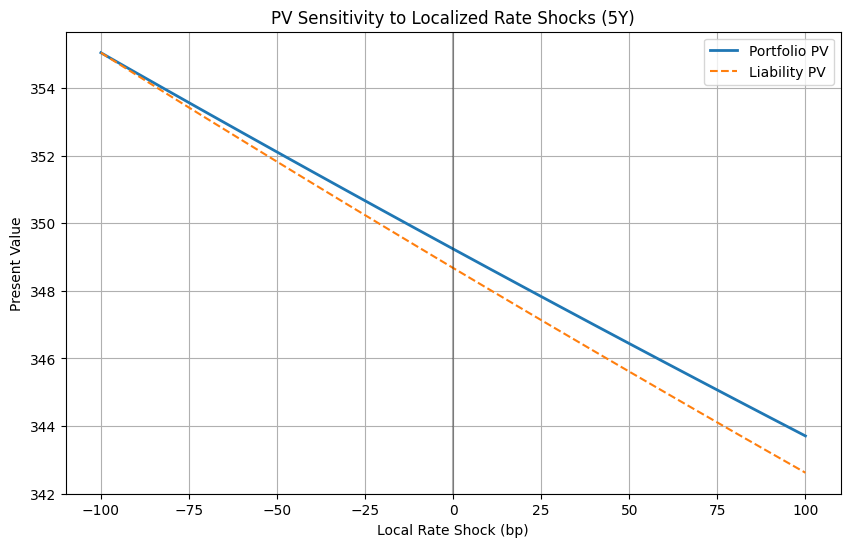

In [36]:
shock_grid = np.arange(-100, 101, 10)

pv_portfolio = []
pv_liability = []

for s in shock_grid:
    sc = LocalShockCurve(yc, center=5, shock_bp=s)
    pv_portfolio.append(portfolio.price(sc))
    pv_liability.append(pv_liabilities(sc, liability_times, liability_cfs))

plt.figure(figsize=(10,6))
plt.plot(shock_grid, pv_portfolio, label="Portfolio PV", linewidth=2)
plt.plot(shock_grid, pv_liability, label="Liability PV", linestyle="--")

plt.axvline(0, color="black", alpha=0.3)
plt.xlabel("Local Rate Shock (bp)")
plt.ylabel("Present Value")
plt.title("PV Sensitivity to Localized Rate Shocks (5Y)")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
def key_rate_duration_liability(times, cfs, yc, key_rate, shock_bp=1):
    base_pv = pv_liabilities(yc, times, cfs)

    shocked_curve = KeyRateShockedCurve(yc, key_rate, shock_bp)
    shocked_pv = pv_liabilities(shocked_curve, times, cfs)

    krd = -(shocked_pv - base_pv) / base_pv / (shock_bp / 10000)
    return krd


In [41]:
SHOCK_BP = 100
DELTA_Y = SHOCK_BP / 10000

key_rates = [2, 5, 10]

P0 = pv_liabilities(yc, liability_times, liability_cfs)

print(f"Base Price: {P0:.4f}\n")

for k in key_rates:
    # --- Actual ΔP ---
    shocked_curve = KeyRateShockedCurve(yc, k, SHOCK_BP)
    P_shocked = pv_liabilities(
    shocked_curve,
    liability_times,
    liability_cfs
)
    actual_dP = P_shocked - P0

    # --- Parallel approx (already computed earlier) ---
    approx_dP_parallel = approx_change  # your existing number

    # --- KRD approx ---
    krd_k = key_rate_duration_liability(
    liability_times,
    liability_cfs,
    yc,
    k
)
    approx_dP_krd = -P0 * krd_k * DELTA_Y

    print(f"Shock @ {k}Y +{SHOCK_BP}bp")
    print(f"Actual ΔP           : {actual_dP:.4f}")
    print(f"Parallel Approx ΔP  : {approx_dP_parallel:.4f}")
    print(f"KRD Approx ΔP       : {approx_dP_krd:.4f}")
    print("-" * 40)

Base Price: 348.6784

Shock @ 2Y +100bp
Actual ΔP           : -1.8463
Parallel Approx ΔP  : -18.5538
KRD Approx ΔP       : -1.8646
----------------------------------------
Shock @ 5Y +100bp
Actual ΔP           : -6.0618
Parallel Approx ΔP  : -18.5538
KRD Approx ΔP       : -6.2131
----------------------------------------
Shock @ 10Y +100bp
Actual ΔP           : -12.4803
Parallel Approx ΔP  : -18.5538
KRD Approx ΔP       : -13.1081
----------------------------------------
